# Sprint 17 - Redes Neuronales (Ejercicios)

En estos ejercicios adicionales vamos a aprender un poco más sobre lo que se puede lograr con redes neuronales. Para ello, continuamos trabajando con los archivos de audio de la base de datos **RAVDESS** y los datos de prueba preparados en el caso visto anteriormente. En concreto vamos a tratar los siguientes dos puntos:

* Mejoramiento de modelos de red neuronal con aumento de datos.
* Visualización y entendimiento de capas de redes neuronales.

## Mejoramiento de modelos con aumento de datos

Una dificultad importante cuando se trabajan con datos cuyo costo de adquisición es alto (como son las imágenes o los audios) se refiere a la falta de observaciones suficientes para entrenar modelos. En este sentido, existen mecanismos robustos que permitan simular registros mediante la aplicación de distorsiones leves a los datos originales, logrando así aumentar la fuente de información base para entrenamiento.

En lo que respecta a audios, existen entre otros los siguientes métodos de distorsión que vamos a aplicar en nuestros datos originales:

* Alteración de velocidad
* Cambio de frecuencia o tono
* Incorporación de ruido

Para empezar importa todo lo necesario desde **pandas**, **numpy**, **matplotlib**, **re**, **warnings**, **glob**, **librosa**, **IPython.display**, **Scikit-Learn** y **tensorflow.keras**. 

In [1]:
# Cargar librerias para manipular datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from glob import glob
import warnings
warnings.filterwarnings(action = "ignore")

# Cargar librerias para tratar audios
import librosa
import IPython.display as ipd

# Cargar librerias para ingenieria y validacion de modelos
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Cargar librerías para redes neuronales
from tensorflow.keras import models, Input, layers, optimizers, utils

Carga la lista con los nombres de los archivos de audio desde la ruta donde los hayas guardado. Usa la función `glob`.

In [2]:
audio_files = glob("audio_speech_actors_01-24/*/*.wav") #La ruta depende de dónde se hayan guardado los archivos de audio descargados
print(f"# Archivos totales: {len(audio_files):,.0f}")

# Archivos totales: 1,440


Veamos entonces cómo funcionan las distorciones antes mencionadas. Carga un archivo de audio de ejemplo, digamos aquel en la posición 100 de la lista. Establece por defecto una duración de 3 segundos y un offset de 0.5 segundos.

In [3]:
sound, sr = librosa.load(audio_files[100], duration  = 3, offset = 0.5)
ipd.Audio(sound, rate = sr)

Modifica este sonido ejemplificativo incrementando su velocidad mediante la función `librosa.effects.time_stretch` con el argumento `rate = 2`. Guarda el resultado en una nueva variable.

In [4]:
sound_fast = librosa.effects.time_stretch(sound, rate = 2)
ipd.Audio(sound_fast, rate = sr)

Cambia ahora la frecuencia o tonalidad del sonido original mediante la función `librosa.effects.pitch_shift` con el argumento `n_steps = 5`. Guarda el resultado en una nueva variable.

In [5]:
sound_pitch = librosa.effects.pitch_shift(sound, sr = sr, n_steps = -5)
ipd.Audio(sound_pitch, rate = sr)

Adiciona ruido al sonido original y guarda el resultado en una nueva variable. Utiliza para esto la siguiente función que incorpora *ruido blanco* en dicho sonido:

```py
def func_ruido (s, intensidad = 0.01):
    noise = np.random.randn(len(s))
    s_noise = s + intensidad * noise
    return s_noise
```

In [6]:
# Crear funcion para incorporar ruido blanco
def func_ruido (s, intensidad = 0.01):
    noise = np.random.randn(len(s))
    s_noise = s + intensidad * noise
    return s_noise

# Incorporar ruido en sonido
sound_noise = func_ruido(sound)
ipd.Audio(sound_noise, rate = sr)

Una vez comprendidas, apliquemos estas distorciones a todos los datos originales. Para esto, crea una función que tome un sonido específico y lo acelere a una tasa aleatoria entre 1 y 1.01, incremente su frecuencia en una cantidad aleatoria de pasos entre -0.5 y 0.5, e incorpore ruido blanco con una instensidad de 0.0001.

In [7]:
# Crear funcion para distorsionar sonido
def func_distorsion (s, sr):

    # Acelerar sonido
    s = librosa.effects.time_stretch(s, rate = 1 + np.random.rand() * 0.01)

    # Cambiar frecuencia
    s = librosa.effects.pitch_shift(s, sr = sr, n_steps = -0.5 + np.random.rand() * 1)

    # Agregar ruido blanco
    s = func_ruido(s, intensidad = 0.0001)

    return s

In [8]:
# Verificar funcionamiento de la funcion
sound_dist = func_distorsion(sound, sr)
ipd.Audio(sound_dist, rate = sr)

Utiliza un bucle para aplicar distorsiones a todos los archivos de audio mediante la función creada. Guarda tus resultados en una variable nueva de tipo lista.

In [9]:
audio_dist = []
for i in range(len(audio_files)):
    
    # Extraer sonido
    sound, sr = librosa.load(audio_files[i], duration  = 3, offset = 0.5)

    # Aplicar distorsion
    sound_dist = func_distorsion(sound, sr)

    # Guardar resultado
    audio_dist.append(sound_dist)

len(audio_dist)

1440

Utiliza otro bucle para guardar en otra lista todos los sonidos originales.

In [10]:
audio_orig = []
for i in range(len(audio_files)):

    # Extraer sonido
    sound, sr = librosa.load(audio_files[i], duration  = 3, offset = 0.5)

    # Guardar resultado
    audio_orig.append(sound)

len(audio_orig)

1440

Concatena la lista de sonidos distorcionados con aquella de sonidos originales y guarda el resultado en una variable.

In [11]:
audio_all = audio_orig + audio_dist
len(audio_all)

2880

Ya tenemos lista nuestra simulación de datos. Si recuerdas del caso precedente, es necesario transformar estos datos a fin de poder utilizarlos en un modelo, por lo que puedes reutilizar código de allí para hacerlo.

In [12]:
# Creaar funcion para transformar datos de audio crudos
def func_transaudio (s):

    sound_ft = librosa.stft(s)
    sound_ft = np.abs(sound_ft.real)
    sound_db = librosa.amplitude_to_db(sound_ft, ref = 0)
    obs = sound_db.mean(axis = 0)

    db_min = min(obs)
    if len(obs) < 130:
        obs = np.append(obs,[db_min] * (130 - len(obs)))

    return obs

In [13]:
# Aplicar funcion para tabular archivos de audio
data_audio = []
for i in range(len(audio_all)):
    data_audio.append(func_transaudio(audio_all[i]))

data_audio = np.array(data_audio)

# Convertir a dataframe
df_audio = pd.DataFrame(
    data_audio,
    columns = ["t" + str(x+1) for x in range(data_audio.shape[1])]
)

df_audio.shape

(2880, 130)

A partir del nombre de los archivos de audio, extrae todas las características relevantes adicionales y guárdalas en una tabla. Esto ya lo hicimos en el caso precedente por lo que nuevamente puedes reutilizar código de allí.

In [14]:
# Extraer todos las caracteristicas de los nombres de archivos
codificacion = []
for a in audio_files:
    codnum = re.search("[0-9]{2}-[0-9]{2}-[0-9]{2}-[0-9]{2}-[0-9]{2}-[0-9]{2}-[0-9]{2}", a)
    codificacion.append(codnum.group().split("-"))

df_codificacion = pd.DataFrame(
    codificacion,
    columns = ["tipo","canal","emocion","intensidad","frase","num_repeticion","id_actor"]
)

# Mantener solamente caracteristicas relevantes
df_codificacion = df_codificacion.drop(columns = ["tipo", "canal", "frase", "num_repeticion"])

# Cambiar la variable objetivo
df_codificacion["emocion"] = df_codificacion["emocion"].astype(int) - 1

# Cambiar la variable de intensidad
df_codificacion["intensidad"] = df_codificacion["intensidad"].astype(int) - 1
df_codificacion = df_codificacion.rename(columns = {"intensidad": "intensidad_alta"})

# Sustituir variable de id del actor
df_codificacion["es_hombre"] = df_codificacion["id_actor"].astype(int).apply(lambda x: 1 if x%2 == 1 else 0)
df_codificacion = df_codificacion.drop(columns = "id_actor")

# Duplicar caracteristicas dado el aumento de datos
df_codificacion = pd.concat([df_codificacion, df_codificacion])
df_codificacion = df_codificacion.reset_index(drop = True)

df_codificacion.shape

(2880, 3)

Une finalmente estas caracteristicas con la información transformada de los sonidos.

In [15]:
df_audio = pd.concat(
    [df_audio, df_codificacion],
    axis = 1
)

df_audio.shape

(2880, 133)

Ejecuta con estos datos los siguientes procesos de ingeniería:

* Separa la variable objetivo de los atributos.
* Escala los atributos con el método de normalización (función `MinMaxScaler`).
* Particiona el dataset aplicando un estado randómico para garantizar la replicabilidad y garantizando que el subconjunto de prueba represente el 20% del total de observaciones.

In [16]:
# Separar atributos de variable objetivo
X = df_audio.drop(columns = "emocion")
y = df_audio["emocion"]

In [17]:
# Escalar atributos
mod_esc = MinMaxScaler()
mod_esc.fit(X)

X = pd.DataFrame(
    mod_esc.transform(X),
    columns = X.columns
)

X.sample(10)

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,...,t123,t124,t125,t126,t127,t128,t129,t130,intensidad_alta,es_hombre
1109,0.528319,0.513443,0.518504,0.521331,0.499247,0.506469,0.536439,0.527710,0.523758,0.513788,...,0.447285,0.432019,0.433273,0.435275,0.428841,0.432236,0.433294,0.438515,0.0,1.0
114,0.428324,0.413521,0.416619,0.419102,0.402030,0.410100,0.433588,0.433190,0.436243,0.423328,...,0.365362,0.353108,0.354061,0.355567,0.351406,0.353081,0.353117,0.358753,0.0,0.0
1584,0.507213,0.509656,0.508498,0.507926,0.489389,0.500564,0.525386,0.516779,0.514645,0.504660,...,0.439905,0.425831,0.428627,0.430599,0.421032,0.423350,0.424213,0.423149,1.0,1.0
2489,0.477101,0.493301,0.498073,0.497916,0.471760,0.483102,0.504163,0.497461,0.490020,0.478773,...,0.425416,0.403947,0.402243,0.400732,0.393345,0.391086,0.371821,0.377385,0.0,0.0
1164,0.556994,0.580460,0.568888,0.569810,0.528989,0.508553,0.536947,0.523500,0.502574,0.460814,...,0.345004,0.333501,0.334549,0.335750,0.332287,0.334090,0.334175,0.339176,1.0,0.0
157,0.491235,0.486359,0.488134,0.491174,0.464812,0.464392,0.482997,0.475938,0.475642,0.468822,...,0.451216,0.438355,0.437420,0.430179,0.414283,0.401726,0.396359,0.400157,0.0,1.0
2842,0.400258,0.429911,0.433454,0.432837,0.420221,0.415309,0.444424,0.436750,0.435970,0.431309,...,0.378424,0.359523,0.368044,0.368176,0.366201,0.361298,0.346983,0.335437,0.0,0.0
2649,0.558347,0.576922,0.560212,0.543488,0.523813,0.532298,0.554985,0.537715,0.525246,0.510168,...,0.437929,0.413376,0.405934,0.402251,0.387563,0.387055,0.380010,0.370634,1.0,1.0
1334,0.423493,0.408670,0.411732,0.414185,0.396964,0.403435,0.426757,0.421154,0.421593,0.410809,...,0.360911,0.348651,0.349608,0.351163,0.347249,0.349133,0.349222,0.354448,0.0,1.0
1000,0.879953,0.872083,0.874805,0.876916,0.838924,0.851836,0.899360,0.886354,0.869980,0.864537,...,0.745035,0.719708,0.721400,0.724584,0.708082,0.711814,0.711994,0.722343,1.0,1.0


In [18]:
# Particionar dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

print(X_train.shape)
print(X_test.shape)

(2304, 132)
(576, 132)


A fin de hacer que los resultados a continuación sean comparables con lo que ya hemos desarrollado en el caso precedente, sustituye el subconjunto de prueba (atributos y variable objetivo) por aquellos guardados y utilizados para evaluar el modelo final anterior.

In [19]:
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")
y_test = y_test["emocion"]

print(X_test.shape)

(288, 132)


Veamos si el aumento de datos que hicimos incrementa la asertividad del modelo. Si recuerdas, en el caso precedente nuestro modelo de red neuronal final mantenía la siguiente arquitectura:

```py
# Crear modelo 
utils.set_random_seed(111)
modelo = models.Sequential(name = "Convolucional")

# Configurar arquitectura
modelo.add(Input(shape = (X_train.shape[1],1)))
modelo.add(layers.Conv1D(filters = 5, kernel_size = 10, strides = 1, padding = "same"))
modelo.add(layers.Activation("relu"))
modelo.add(layers.Dropout(rate = 0.1))
modelo.add(layers.MaxPooling1D(pool_size = 10, strides = 2, padding = "valid"))
modelo.add(layers.Dropout(rate = 0.1))
modelo.add(layers.Flatten())
modelo.add(layers.Dense(units = len(y.unique())))
modelo.add(layers.Activation("softmax"))

modelo.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = optimizers.Adam(learning_rate = 0.001),
    metrics = ["acc"]
)
```

Y con 250 iteraciones de retropropagación, su resultado a nivel de exactitud alcanzo un valor entre 55% y 60%. 

Entrena entonces esta red neuronal nuevamente con los datos aumentados y evalua su rendimiento para verificar si se puede superar este umbral.

In [20]:
# Crear modelo 
utils.set_random_seed(111)
modelo = models.Sequential(name = "Convolucional")

# Configurar arquitectura
modelo.add(Input(shape = (X_train.shape[1],1)))
modelo.add(layers.Conv1D(filters = 5, kernel_size = 10, strides = 1, padding = "same"))
modelo.add(layers.Activation("relu"))
modelo.add(layers.Dropout(rate = 0.1))
modelo.add(layers.MaxPooling1D(pool_size = 10, strides = 2, padding = "valid"))
modelo.add(layers.Dropout(rate = 0.1))
modelo.add(layers.Flatten())
modelo.add(layers.Dense(units = len(y.unique())))
modelo.add(layers.Activation("softmax"))

modelo.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = optimizers.Adam(learning_rate = 0.001),
    metrics = ["acc"]
)

modelo.summary()

Model: "Convolucional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 132, 5)         │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 132, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 132, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 62, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 310)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         2,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 8)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,543 (9.93 KB)

 Trainable params: 2,543 (9.93 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Entrenar el modelo
train_mod = modelo.fit(
    X_train,
    y_train,
    epochs = 250,
    validation_data = (X_test, y_test),
    verbose = 0
)

In [22]:
# Generar predicciones
y_pred = modelo.predict(X_test)
y_pred = [np.argmax(x) for x in y_pred]

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


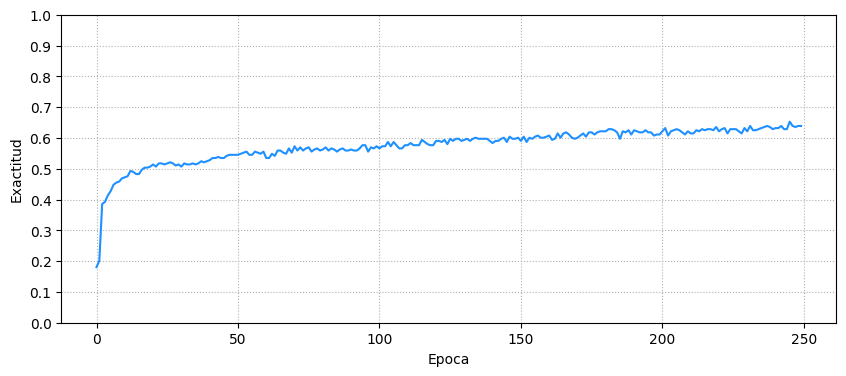

In [23]:
# Visualizar evolución de exactitud
plt.figure(figsize = [10,4])
plt.plot(train_mod.history["val_acc"], color = "dodgerblue")
plt.xlabel("Epoca")
plt.ylabel("Exactitud")
plt.ylim([0,1])
plt.yticks(np.array(range(0,11))/10)
plt.grid(linestyle = ":")
plt.show()

In [24]:
# Crear matriz de confusion
pd.crosstab(
    index = y_test,
    columns = y_pred,
    rownames = ["Obs"],
    colnames = ["Pred"]
).style.background_gradient(cmap="Reds") 

Pred,0,1,2,3,4,5,6,7
Obs,,,,,,,,
0,11,4,1,0,0,1,0,0
1,1,24,2,2,0,0,2,0
2,2,0,18,0,3,7,2,9
3,1,6,0,20,0,2,1,6
4,0,0,1,0,39,1,3,2
5,0,1,4,0,6,13,0,6
6,2,2,3,3,5,0,30,2
7,1,0,1,0,4,3,2,29


In [25]:
# Crear reporte de clasificacion
print(classification_report(y_test,y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.6111    0.6471    0.6286        17
           1     0.6486    0.7742    0.7059        31
           2     0.6000    0.4390    0.5070        41
           3     0.8000    0.5556    0.6557        36
           4     0.6842    0.8478    0.7573        46
           5     0.4815    0.4333    0.4561        30
           6     0.7500    0.6383    0.6897        47
           7     0.5370    0.7250    0.6170        40

    accuracy                         0.6389       288
   macro avg     0.6391    0.6325    0.6272       288
weighted avg     0.6477    0.6389    0.6339       288



## Visualización y entendimiento de capas

Como ya se vio, las redes neuronales están compuestas por una o varias capas, y a veces puede ser útil conocer cómo éstas funcionan. Una forma de hacerlo es a través de la extracción de salidas intermedias generadas por las mismas. Tomemos entonces como referencia nuestra red neuronal mejorada por aumento de datos, de la cual debes consultar las capas de este modelo mediante el atributo `layers`.

In [26]:
modelo.layers

[<Conv1D name=conv1d, built=True>,
 <Activation name=activation, built=True>,
 <Dropout name=dropout, built=True>,
 <MaxPooling1D name=max_pooling1d, built=True>,
 <Dropout name=dropout_1, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Activation name=activation_1, built=True>]

Como puedes observar, para una correcta identificación de cada capa la red neuronal les signa un nombre, guarda entonces estos nombres en una lista utilizando el atributo `name`. 

In [27]:
nombres_capas = [x.name for x in modelo.layers]
nombres_capas

['conv1d',
 'activation',
 'dropout',
 'max_pooling1d',
 'dropout_1',
 'flatten',
 'dense',
 'activation_1']

Extraigamos la información de la capa convolucional. Haslo con el método `get_layer` del modelo especificando la capa que queremos extraer y guarda el resultado en la variable `capa_conv`.

In [28]:
capa_conv = modelo.get_layer(nombres_capas[0])
capa_conv

<Conv1D name=conv1d, built=True>

Podemos crear un "submodelo" que considere únicamente esta capa convolucional a fin de estudiar qué es lo que predice por sí sola. Crea por tanto este submodelo con la función `models.Model` y especifica como argumentos de la función `inputs = capa_conv.input` y `outputs = capa_conv.output`.

In [29]:
submodelo = models.Model(inputs = capa_conv.input, outputs = capa_conv.output, name = "Submodelo")
submodelo.summary()

Model: "Submodelo"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 132, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 132, 5)         │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55 (220.00 B)

 Trainable params: 55 (220.00 B)

 Non-trainable params: 0 (0.00 B)

Procesa un sonido ejemplo cualquiera de los datos de prueba en tu submodelo, digamos el que se encuentra en la posición 65. 

In [30]:
# Extraer un sonido de ejemplo
obs = 65
sound_orig = X_test.iloc[obs]

# Ajustar las dimensiones del sonido a fin que correspondan con las entradas requeridas en el submodelo
sound_orig_input = sound_orig.values.reshape(1, 132, 1)

# Generar salidas del submodelo
salida = submodelo(sound_orig_input)

# Ajustar dimensiones de las salidas para mejor entendimiento de las mismas
salida = salida.numpy().reshape(132,5)

Visualiza las salidas generadas en esta capa y constrástalas con el audio original. Recuerda que esta capa convolucional tiene 5 filtros.

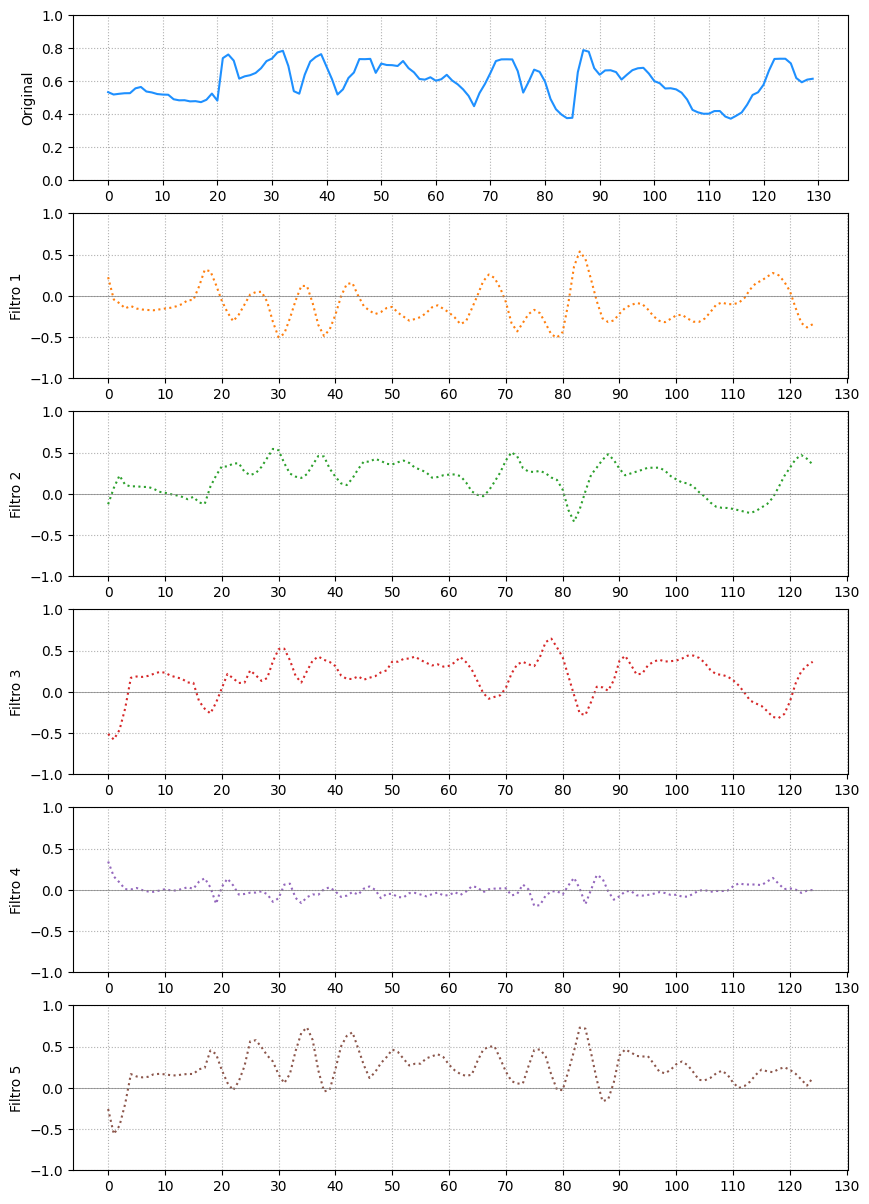

In [31]:
fig, ax = plt.subplots(6, 1, figsize = [10,15], squeeze = True)
ax[0].plot(sound_orig[:130], color = "dodgerblue")
ax[0].grid(linestyle = ":")
ax[0].set_xticks(ticks = range(0,140,10), labels = range(0,140,10))
ax[0].set_ylabel("Original")
ax[0].set_ylim([0,1])
for i in range(salida.shape[1]):
    sound_f = salida[:,i]
    sound_f = sound_f[:125]
    ax[i + 1].plot(sound_f, color = f"C{i + 1}", linestyle = "dotted")
    ax[i + 1].grid(linestyle = ":")
    ax[i + 1].set_xticks(ticks = range(0,140,10), labels = range(0,140,10))
    ax[i + 1].set_ylabel(f"Filtro {i + 1}")
    ax[i + 1].set_ylim([-1,1])
    ax[i + 1].axhline(y = 0, linewidth = 0.5, color = "gray")
plt.show()

Ante estos resultados, queda la interrogante respecto a cómo surgieron estas salidas. A continuación por tanto intentaremos replicarlos de forma manual, y de esta manera poder comprender mejor que hace una capa convolucional. Para esto, inicia guardando los resultados de la salida generada por el filtro 1.

In [32]:
salida_f1 = salida[:,0]

Extrae a continuación los pesos generados en la capa aplicando el método `get_weights`. Guarda en variables aparte aquellos pesos correspondientes al primer filtro.

In [33]:
# Extraer todos los pesos de todas las capas
pesos, interceptos = capa_conv.get_weights()
pesos = pesos.reshape(10,5)

print("Pesos de capas:")
print(pesos)
print()
print("Pesos de intercepto de capas:")
print(interceptos)

Pesos de capas:
[[ 0.1077471  -0.05339563  0.632053   -0.06305626  0.7721689 ]
 [-0.0521305  -0.24022323  0.45965302 -0.11683853  0.5149193 ]
 [-0.06704753  0.22598103  0.19262314 -0.09689381  0.13640365]
 [-0.5726677   0.37743738 -0.08416491 -0.35288432 -0.5908672 ]
 [-0.6582968   0.35006696  0.49882784 -0.01989621 -0.3465943 ]
 [-0.45702797  0.52414435  0.56526595  0.788865   -0.48872706]
 [-0.17183147  0.31889778  0.1963045  -0.3806176  -0.09286143]
 [ 0.04094366  0.7181091  -0.3718262  -0.5578684   0.89671904]
 [ 0.76368237  0.01898339 -0.38312647  0.03858837  0.2561741 ]
 [ 0.75227636 -0.3757102  -0.79336697  0.4448974   0.20923719]]

Pesos de intercepto de capas:
[ 0.06026208 -0.9329883  -0.33428255  0.1688271  -0.49446827]


In [34]:
# Guardar pesos de primer filtro
w_1 = pesos[:,0]
b_1 = interceptos[0]

Dado que en la definición de la capa se utilizó el argumento `padding = "same"`, las salidas generadas tendrán el mismo tamaño que la entrada. Entonces para aplicar el proceso de suavizamiento propio de la convolución, utiliza la función `np.pad` en el sonido original de forma que se cuente con 4 valores adicionales de 0 al inicio, y 5 valores de 0 al final. Este ajuste es lo que se conoce justamente como **padding**.

In [35]:
sound_pad = np.pad(sound_orig,(4, 5))
sound_pad

array([0.        , 0.        , 0.        , 0.        , 0.53419281,
       0.51975254, 0.52404408, 0.52747012, 0.52792861, 0.55715981,
       0.56550937, 0.5380427 , 0.53235086, 0.52265665, 0.5194353 ,
       0.51846177, 0.49103731, 0.48459666, 0.48525436, 0.47820456,
       0.47951243, 0.47354784, 0.48790024, 0.52543848, 0.48267128,
       0.74016848, 0.76225879, 0.72514993, 0.61594831, 0.62991803,
       0.63683622, 0.65039034, 0.6791603 , 0.72219771, 0.73771973,
       0.77446025, 0.78479155, 0.69238472, 0.53990606, 0.52478035,
       0.63986041, 0.71936091, 0.7470674 , 0.76443893, 0.68850049,
       0.61165703, 0.51982462, 0.55120217, 0.61997962, 0.65312252,
       0.73447656, 0.73401584, 0.73578736, 0.65110198, 0.70728254,
       0.69867912, 0.69762591, 0.69256562, 0.72286859, 0.67966386,
       0.6541467 , 0.6139212 , 0.60996034, 0.62425615, 0.60339347,
       0.61230274, 0.63920674, 0.6043377 , 0.58166681, 0.55079905,
       0.51133597, 0.44899884, 0.52869162, 0.58425812, 0.65054

Sea entonces 

* $x$ el vector que contiene el sonido original con *padding*.
* $w_1$ los pesos específicos del filtro
* $b_1$ el intercepto. 
* $k$ el tamaño del kernel (en nuestra capa convolucional este valor es de 10).

Por tanto la convolusión consistirá en aplicar la siguiente fórmula para cada elemento de la salida $y$:

$$ y_i = x_{(i,i + k)} \cdot w_1^T + b_1, \quad \forall  i <= |x| $$

Ejecuta esta convolución y visualiza si coincide el resultado con la salida generada previamente.

In [36]:
# Ejecutar convolusión del primer flitro
k = 10
y = np.zeros(len(sound_orig))
for i in range(len(y)):
    y[i] = sound_pad[i:(i + k)] @ w_1.T + b_1

y

array([ 2.24920413e-01, -4.54153386e-02, -9.05211349e-02, -1.52261834e-01,
       -1.24061134e-01, -1.54731861e-01, -1.66773351e-01, -1.72327317e-01,
       -1.75729900e-01, -1.65439984e-01, -1.54962214e-01, -1.45221886e-01,
       -1.27449204e-01, -1.01109311e-01, -5.43586984e-02, -5.08285456e-02,
        1.12529670e-01,  3.13954938e-01,  2.97962683e-01,  1.30319318e-01,
       -5.94194121e-02, -2.00663029e-01, -3.08432588e-01, -2.27859780e-01,
       -1.06905478e-01,  1.57464740e-02,  4.49454436e-02,  4.87404630e-02,
       -7.33767906e-02, -3.16207760e-01, -5.03136261e-01, -4.59201869e-01,
       -2.71722641e-01, -5.68893434e-02,  1.20090438e-01,  1.18001561e-01,
       -8.91234857e-02, -3.54878849e-01, -4.86564890e-01, -4.06974078e-01,
       -2.30893897e-01, -4.95802480e-03,  1.43652418e-01,  1.53752293e-01,
        9.89075349e-04, -1.25250394e-01, -1.81056344e-01, -2.21088970e-01,
       -1.97676408e-01, -1.48890986e-01, -1.34161238e-01, -2.04733539e-01,
       -2.52685483e-01, -

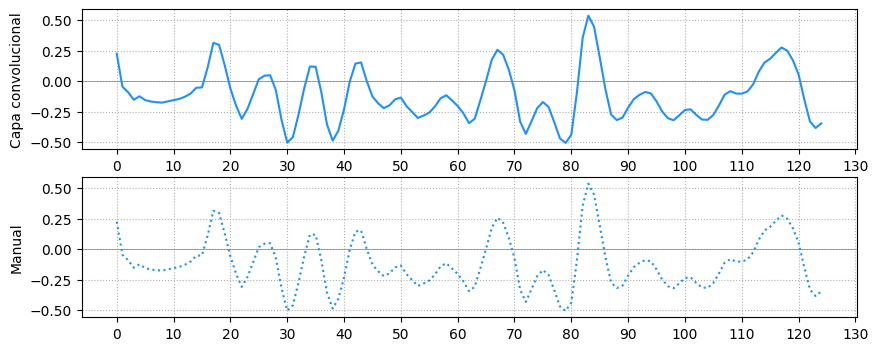

In [37]:
# Visualizar si salidas manual coincide con salida generada desde red neuronal 
fig, ax = plt.subplots(2, 1, figsize = [10,4], squeeze = True)
ax[0].plot(salida_f1[:125], color = "dodgerblue")
ax[0].set_xticks(ticks = range(0,140,10), labels = range(0,140,10))
ax[0].set_ylabel("Capa convolucional")
ax[0].grid(linestyle = ":")
ax[0].axhline(y = 0, linewidth = 0.5, color = "gray")
ax[1].plot(y[:125], linestyle = "dotted", color = "dodgerblue")
ax[1].set_xticks(ticks = range(0,140,10), labels = range(0,140,10))
ax[1].grid(linestyle = ":")
ax[1].set_ylabel("Manual")
ax[1].axhline(y = 0, linewidth = 0.5, color = "gray")
plt.show()

La coincidencia es exacta y lo mismo ocurrirá si ejecutamos esta lógica con los demás filtros. Si gustas intentarlo, haslo.

Como puedes evidenciar, la convolución es un proceso de suavizamiento de la entrada original que nos permite contar con diferentes perspectivas de la señal de audio. Lo anterior a fin de destacar características específicas del sonido. Notemos por ejemplo la relación existente entre la salida del filtro 1 con el surgimiento de los valles de dB.

Lo anterior queda más claro cuando aplicamos la siguiente capa de la red neuronal mejorada y que corresponde la activación **ReLu** a las salidas convolucionales. Ejecuta esta operación en la salida del primer filtro y contrasta el resultado con el sonido original. Recuerda que la función ReLu, se define por

$$ y = \max{(0,x)} $$

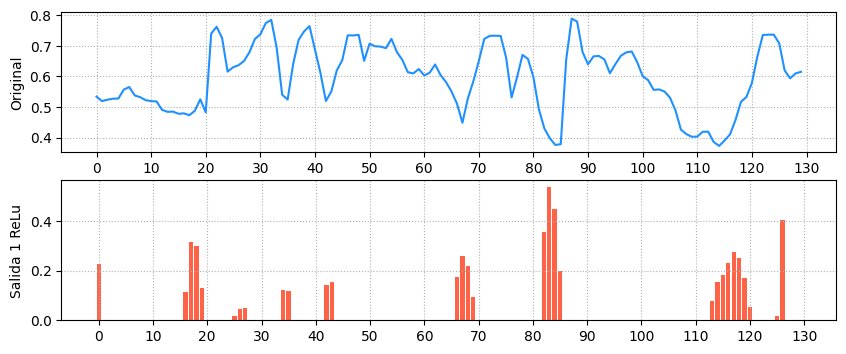

In [38]:
# Aplicar ReLu a salida convolucional
y_relu = np.maximum(0, y)

# Visualizar salida con ReLu y entrada original
fig, ax = plt.subplots(2, 1, figsize = [10,4], squeeze = True)
ax[0].plot(sound_orig[:130], color = "dodgerblue")
ax[0].set_xticks(ticks = range(0,140,10), labels = range(0,140,10))
ax[0].set_ylabel("Original")
ax[0].grid(linestyle = ":")
ax[1].bar(height = y_relu[:130], x = range(len(y_relu[:130])), color = "tomato")
ax[1].set_xticks(ticks = range(0,140,10), labels = range(0,140,10))
ax[1].grid(linestyle = ":")
ax[1].set_ylabel("Salida 1 ReLu")
ax[1].axhline(y = 0, linewidth = 0.5, color = "gray")
plt.show()